# Markov Decision Process (MDP)

In [21]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [22]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [23]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

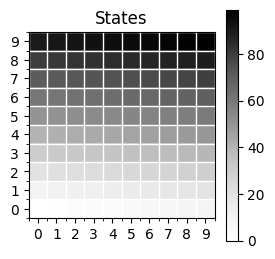

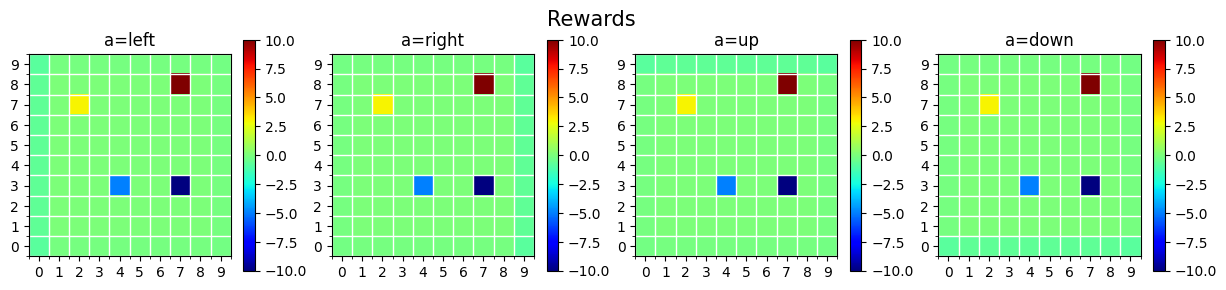

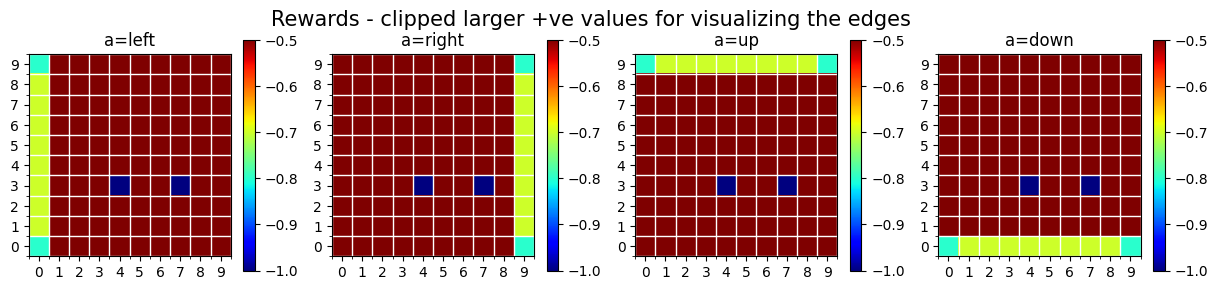

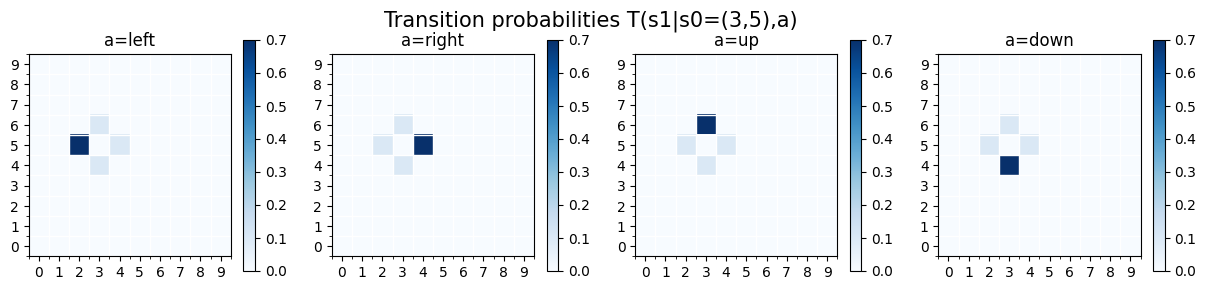

In [24]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [25]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

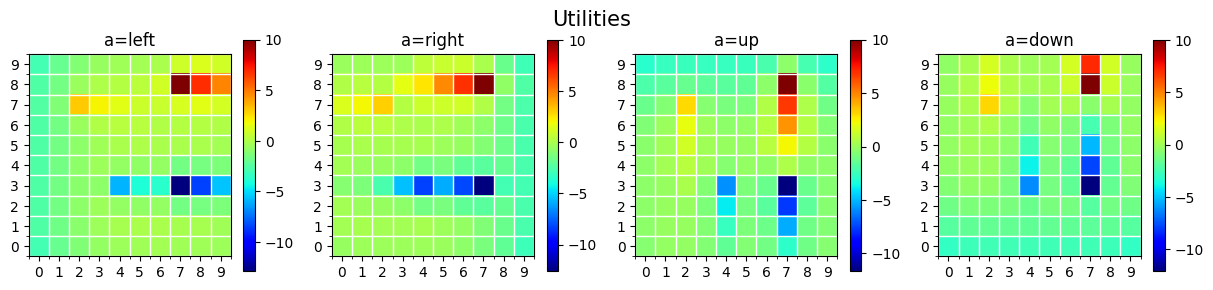

In [26]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        #type your code here
        U = mdp.R[:, policy] + mdp.discount * np.sum(mdp.T[:, policy, :] * U_old, axis=1)
        U_old = copy.copy(U)
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [27]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

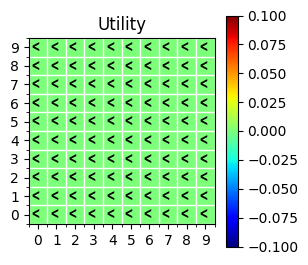

In [28]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        f#type your code here
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    #type your code here
    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [29]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [30]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S)) #initial values
    pi_k = np.random.randint(low=0,high=4,size=len(mdp.S),dtype=int) #initial policy
    pi_kp1 = copy.copy(pi_k)
    for t in range(numIterations):
        #Policy evaluation: compute U_pi_k
        U_pi_k = iterativePolicyEvaluation(mdp, policy=pi_k, numIterations=10) # Using iterativePolicyEvaluation from earlier
        #Policy improvement
        Q = mdp.R + mdp.discount * np.sum(mdp.T * U_pi_k[:, np.newaxis], axis=2)
        pi_kp1 = np.argmax(Q, axis=1)
        if np.array_equal(pi_k, pi_kp1):
            break # Policy has converged
        pi_k = copy.copy(pi_kp1)
    return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [31]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

# Questions


In the MDP (Markov Decision Process) notebook, modify the code to compare the execution
time and convergence between

• A Model-Based approach (e.g., Policy Iteration or Value Iteration)

• A Model-Free approach (e.g., Q-Learning).

--- Running Policy Iteration (Model-Based) ---
PI Execution Time: 0.1856 seconds
PI Convergence Iterations: 5

--- Running Q-Learning (Model-Free, Simulated) ---
QL Execution Time: 25.6511 seconds (over 20000 episodes)
QL Convergence Episodes (sampled): 20000 episodes

--- Comparison Summary ---
| Algorithm | Approach | Time (s) | Convergence Metric |
|:----------|:---------|:---------|:-------------------|
| PI        | Model-Based | 0.1856 | 5 iterations |
| QL        | Model-Free | 25.6511 | 20000 episodes |


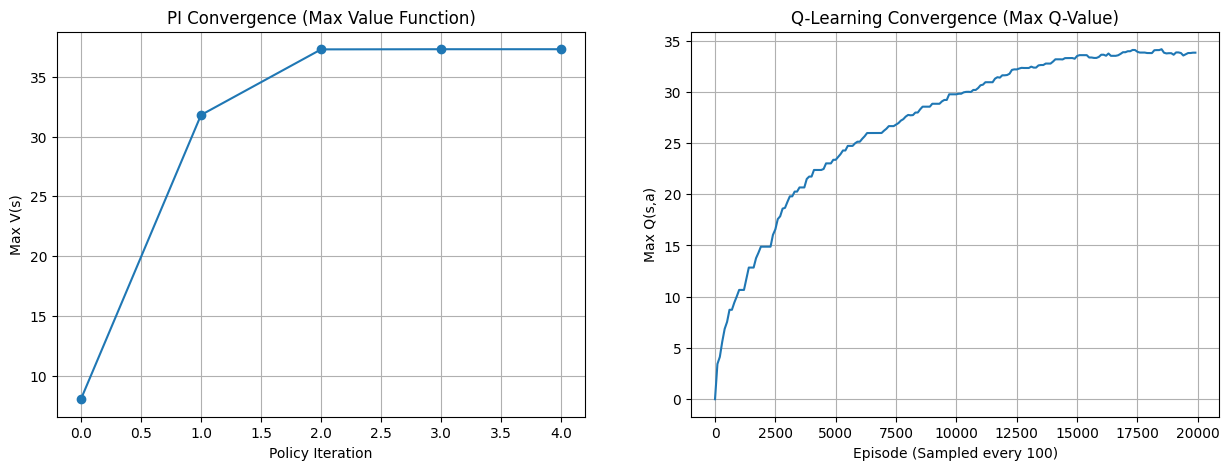

In [33]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

def createGrid10World():
    # Helper function to create a 10x10 gridworld MDP
    size = 10
    S = list(range(size*size))
    A = [0, 1, 2, 3] # UP, DOWN, LEFT, RIGHT
    R = np.full((len(S), len(A)), -1.0)
    T = np.zeros((len(S), len(A), len(S)))
    nextStates = { (s, a): [] for s in S for a in A }

    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    for s in S:
        x, y = s2xy(s)

        # Define possible next states for each intended action
        moves = {
            0: (x, y + 1), # UP
            1: (x, y - 1), # DOWN
            2: (x - 1, y), # LEFT
            3: (x + 1, y)  # RIGHT
        }

        for a_idx, (nx, ny) in moves.items():
            intended_s_prime = xy2s(nx, ny)

            # Calculate probabilities for intended and off-grid moves
            prob_intended = 0.7
            prob_other = 0.1

            # Transitions: 0.7 in intended direction, 0.1 in other three
            possible_moves = [(x, y + 1), (x, y - 1), (x - 1, y), (x + 1, y)]
            for other_a_idx, (onx, ony) in enumerate(possible_moves):
                if other_a_idx == a_idx:
                    T[s, a_idx, intended_s_prime] += prob_intended
                else:
                    T[s, a_idx, xy2s(onx, ony)] += prob_other

            # Ensure probabilities sum to 1 (due to potential rounding or edge cases)
            T[s, a_idx, :] /= np.sum(T[s, a_idx, :])


    # Special states (goal and bomb) - using the original coordinates
    goal_state_coords = (7, 8) # y, x
    bomb_state_coords = (4, 3) # y, x
    bomb_state2_coords = (7, 3) # y, x
    goal_state = xy2s(*goal_state_coords)
    bomb_state = xy2s(*bomb_state_coords)
    bomb_state2 = xy2s(*bomb_state2_coords)

    # Rewards based on the original description
    R[goal_state, :] = 10
    R[xy2s(2,7), :] = 3 # Original smaller positive reward
    R[bomb_state, :] = -5 # Original smaller negative reward
    R[bomb_state2, :] = -10 # Original larger negative reward

    # Edge/Corner rewards (based on the original description)
    for y in [0, 9]:
        for x in [0, 9]:
            s = xy2s(x, y)
            R[s, :] = -0.2
            if x == 0: R[s, 2] = -0.7 # Left action at left edge
            if x == 9: R[s, 3] = -0.7 # Right action at right edge
            if y == 0: R[s, 1] = -0.7 # Down action at bottom edge
            if y == 9: R[s, 0] = -0.7 # Up action at top edge

    for y in [0, 9]:
        for x in range(1, 9):
            s = xy2s(x, y)
            R[s, :] = -0.1
            if y == 0: R[s, 1] = -0.7 # Down action at bottom edge
            if y == 9: R[s, 0] = -0.7 # Up action at top edge

    for x in [0, 9]:
        for y in range(1, 9):
            s = xy2s(x, y)
            R[s, :] = -0.1
            if x == 0: R[s, 2] = -0.7 # Left action at left edge
            if x == 9: R[s, 3] = -0.7 # Right action at right edge


    # Update transitions for terminal states (goal and bomb states)
    # In the original problem description, these states are not terminal,
    # but for a typical RL setup, they often are. Let's keep them non-terminal
    # as per the original MDP definition provided earlier.
    # T[goal_state, :, :] = 0
    # T[goal_state, :, goal_state] = 1.0
    # T[bomb_state, :, :] = 0
    # T[bomb_state, :, bomb_state] = 1.0
    # T[bomb_state2, :, :] = 0
    # T[bomb_state2, :, bomb_state2] = 1.0


    discount = 0.9

    # Recalculate nextStates based on the corrected T
    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where(T[si, ai, :] > 1e-9)[0] # Use a small tolerance for floating point


    return {'S': S, 'A': A, 'R': R, 'T': T, 'nextStates': nextStates, 'discount': discount, 'xy2s': xy2s, 's2xy': s2xy}


class MDP():
    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.nextStates = mdp_dict['nextStates']
        self.discount = mdp_dict['discount']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']


class PolicyIterationAgent(MDP):
    def __init__(self, mdp_dict):
        self.inbuilt_init(mdp_dict)
        self.policy = np.zeros(len(self.S), dtype=int)

    # 1. Policy Evaluation
    def policy_evaluation(self, policy, V_init, tol=1e-3):
        V = copy.copy(V_init)
        while True:
            V_new = np.zeros(len(self.S))
            delta = 0
            for s in self.S:
                a = policy[s]
                V_s = 0
                # Iterate over possible next states for the given state and action
                for s_prime in self.nextStates[(s, a)]:
                     # Get the probability of transitioning to s_prime
                    p = self.T[s, a, s_prime]
                    r = self.R[s, a]
                    V_s += p * (r + self.discount * V[s_prime])
                V_new[s] = V_s
                delta = max(delta, np.abs(V_new[s] - V[s]))
            V = V_new
            if delta < tol:
                break
        return V


    # 2. Policy Improvement
    def policy_improvement(self, V):
        policy_stable = True
        new_policy = np.zeros(len(self.S), dtype=int)

        for s in self.S:
            old_action = self.policy[s]
            Q_s = np.zeros(len(self.A))

            for a in range(len(self.A)):
                Q_s_a = 0
                # Iterate over possible next states for the given state and action
                for s_prime in self.nextStates[(s, a)]:
                    # Get the probability of transitioning to s_prime
                    p = self.T[s, a, s_prime]
                    r = self.R[s, a]
                    Q_s_a += p * (r + self.discount * V[s_prime])
                Q_s[a] = Q_s_a

            new_action = np.argmax(Q_s)
            new_policy[s] = new_action

            if old_action != new_action:
                policy_stable = False

        self.policy = new_policy
        return new_policy, policy_stable

    # 3. Policy Iteration Loop
    def policy_iteration(self, V_init, tol=1e-3):
        start_time = timeit.default_timer()
        V = copy.copy(V_init)
        history = []
        i = 0
        while True:
            V = self.policy_evaluation(self.policy, V, tol)
            history.append(V)

            new_policy, policy_stable = self.policy_improvement(V)
            i += 1
            if policy_stable:
                break

        end_time = timeit.default_timer()
        execution_time = end_time - start_time

        return V, new_policy, history, execution_time, i

class QLearningSimulatedAgent(MDP):
    def __init__(self, mdp_dict, alpha=0.1, epsilon=0.1, gamma=0.9):
        self.inbuilt_init(mdp_dict)
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = np.zeros((len(self.S), len(self.A)))
        self.history_max_Q = []

    def _choose_action(self, s):
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.A))
        else:
            return np.argmax(self.Q[s, :])

    def learn(self, num_episodes):
        start_time = timeit.default_timer()

        for episode in range(num_episodes):
            s = np.random.choice(self.S)

            if episode % 100 == 0:
                self.history_max_Q.append(np.max(self.Q))

            for _ in range(100): # Limit steps per episode to avoid infinite loops
                a = self._choose_action(s)

                # Simulate step using MDP model (T, R)
                next_states = self.nextStates[(s, a)]
                probabilities = self.T[s, a, next_states]

                # Handle cases where probabilities might be zero (though the fix should prevent this)
                # Add a small epsilon to probabilities if they sum to zero to avoid error in np.random.choice
                if np.sum(probabilities) < 1e-9:
                    probabilities = np.ones(len(next_states)) / len(next_states)

                s_prime = np.random.choice(next_states, p=probabilities)
                r = self.R[s, a]

                # Q-Learning Update
                max_future_Q = np.max(self.Q[s_prime, :])
                td_target = r + self.gamma * max_future_Q
                td_error = td_target - self.Q[s, a]
                self.Q[s, a] = self.Q[s, a] + self.alpha * td_error

                s = s_prime
                # If s_prime is a state with a significant reward/penalty, consider it a terminal state for the episode
                # based on the original problem description, states (7,8), (2,7), (4,3), and (7,3) have specific rewards.
                # We can treat reaching these as ending an episode for Q-Learning simulation purposes.
                goal_states_for_termination = [self.xy2s(7,8), self.xy2s(2,7), self.xy2s(4,3), self.xy2s(7,3)]
                if s_prime in goal_states_for_termination:
                     break


        end_time = timeit.default_timer()
        execution_time = end_time - start_time

        optimal_policy = np.argmax(self.Q, axis=1)

        return self.Q, optimal_policy, self.history_max_Q, execution_time, num_episodes

# --- Task 1: Comparison between Model-Based and Model-Free ---
mdp_dict = createGrid10World()
V_init = np.zeros(len(mdp_dict['S']))
EPISODES = 20000

# 1. Model-Based: Policy Iteration
pi_agent = PolicyIterationAgent(mdp_dict)
print("--- Running Policy Iteration (Model-Based) ---")
V_pi, policy_pi, hist_pi, time_pi, iters_pi = pi_agent.policy_iteration(V_init)
print(f"PI Execution Time: {time_pi:.4f} seconds")
print(f"PI Convergence Iterations: {iters_pi}")

# 2. Model-Free: Q-Learning (Simulated)
ql_agent = QLearningSimulatedAgent(mdp_dict)
print("\n--- Running Q-Learning (Model-Free, Simulated) ---")
Q_ql, policy_ql, hist_ql, time_ql, episodes_ql = ql_agent.learn(num_episodes=EPISODES)
print(f"QL Execution Time: {time_ql:.4f} seconds (over {episodes_ql} episodes)")
print(f"QL Convergence Episodes (sampled): {episodes_ql} episodes")

# --- Results Summary ---
print("\n--- Comparison Summary ---")
print(f"| Algorithm | Approach | Time (s) | Convergence Metric |")
print(f"|:----------|:---------|:---------|:-------------------|")
print(f"| PI        | Model-Based | {time_pi:.4f} | {iters_pi} iterations |")
print(f"| QL        | Model-Free | {time_ql:.4f} | {episodes_ql} episodes |")

# Plotting Convergence
fig, ax = pl.subplots(1, 2, figsize=(15, 5))

ax[0].plot(np.arange(len(hist_pi)), [np.max(v) for v in hist_pi], marker='o')
ax[0].set_title('PI Convergence (Max Value Function)')
ax[0].set_xlabel('Policy Iteration')
ax[0].set_ylabel('Max V(s)')
ax[0].grid(True)

ax[1].plot(np.arange(0, EPISODES, 100)[:len(hist_ql)], hist_ql)
ax[1].set_title('Q-Learning Convergence (Max Q-Value)')
ax[1].set_xlabel(f'Episode (Sampled every 100)')
ax[1].set_ylabel('Max Q(s,a)')
ax[1].grid(True)

pl.show()

##Briefly explain the difference between Model-Based and Model-Free algorithms.

A Model-Based algorithm learns a "map" of the environment. This map includes the transition probabilities for moving between states and the rewards associated with those transitions.  The agent uses this internal model to plan and calculate the optimal path before taking any action, which makes it very efficient.

A Model-Free algorithm, on the other hand, learns directly through trial and error. It does not create a map of the environment but instead learns the value of each action in each state by repeatedly interacting with the environment and observing the outcomes.  This approach is less computationally intensive but often requires a large number of interactions to find an optimal policy.